<a href="https://colab.research.google.com/github/smileysim01/emotionAnalysis/blob/master/emotionAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

***Importing Libraries***

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files 
import io
import nltk
from bs4 import BeautifulSoup
import re

nltk.download("punkt")
nltk.download("stopwords")

from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.externals import joblib

import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, StratifiedKFold, learning_curve

!pip3 install emoji
pd.set_option('display.max_colwidth', -1)
from time import time
import re
import string
import os
import emoji
from pprint import pprint
import collections

import seaborn as sns
sns.set(style="darkgrid")
sns.set(font_scale=1.3)

import gensim
import warnings
warnings.filterwarnings('ignore')
np.random.seed(37)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


     |████████████████████████████████| 51kB 1.5MB/s 
  Created wheel for emoji: filename=emoji-0.6.0-cp36-none-any.whl size=49714 sha256=10dd166158c3a86a468171e58ac4538ac153b570c373d406ef165da24f5858a1
  Stored in directory: /root/.cache/pip/wheels/46/2c/8b/9dcf5216ca68e14e0320e283692dce8ae321cdc01e73e17796
Successfully built emoji


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


***Loading Data***

Saving text_emotion.csv to text_emotion.csv


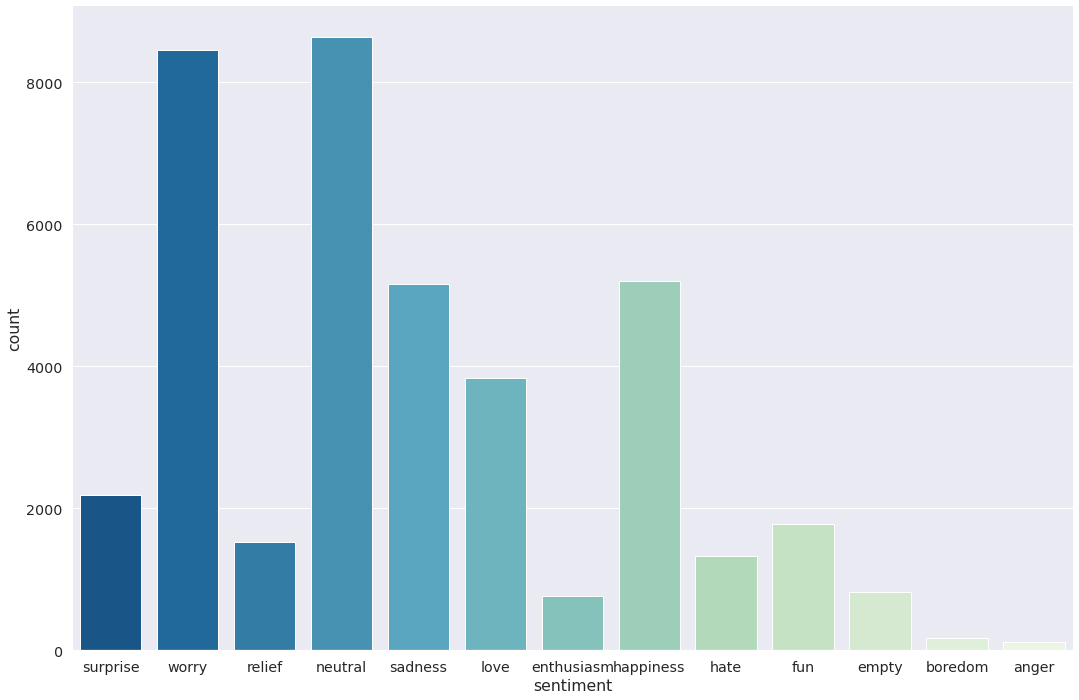

In [ ]:
emotions_csv = files.upload()
emotions_train = pd.read_csv(io.BytesIO(emotions_csv['text_emotion.csv']))
emotions_train = emotions_train.reindex(np.random.permutation(emotions_train.index))
emotions_train = emotions_train[['content','sentiment']]

sns.factorplot(x="sentiment", data=emotions_train, kind="count", size=10, aspect=1.5, palette="GnBu_r")
plt.show();

***Clean Text***

In [ ]:
class CleanText(BaseEstimator, TransformerMixin):

  def remove_mentions(self, input_text):

    return re.sub(r'@\w+', '', input_text)




  def remove_urls(self, input_text):

    return re.sub(r'http.?://[^\s]+[\s]?', '', input_text)




  def emoji_oneword(self, input_text):

    #By compressing the underscore, the emoji is kept as one word

    return input_text.replace('_', '')




  def remove_punctuation(self, input_text):

    #Make translation table

    punct = string.punctuation

    trantab = str.maketrans(punct, len(punct)*' ') #Every punctuation symbol will be replaced by a space

    return input_text.translate(trantab)




  def remove_digits(self, input_text):

    return re.sub('\d+', '', input_text)




  def to_lower(self, input_text):

    return input_text.lower()



  def remove_stopwords(self, input_text):

    stopwords_list = stopwords.words('english')

    #Some words which might indicate a certain sentiment are kept via a whitelist
    emotion_file = files.upload()
    emotion_file = open('emotions.txt',encoding='utf-8').read() 
    from nltk.tokenize import sent_tokenize, word_tokenize
    tokenized_text = sent_tokenize(emotions_train.content)
    print(tokenized_text)
    whitelist = []
    for line in tokenized_text:
      if line is not "'" and line is not ':' and line is not ',':
        whitelist.append(line.strip("'"))

    words = input_text.split()

    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1]

    return " ".join(clean_words)




  def stemming(self, input_text):

    porter = PorterStemmer()

    words = input_text.split()

    stemmed_words = [porter.stem(word) for word in words]

    return " ".join(stemmed_words)




  def fit(self, X, y=None, **fit_params):

    return self




  def transform(self, X, **transform_params):

    clean_X = X.apply(self.remove_mentions).apply(self.remove_urls).apply(self.emoji_oneword).apply(self.remove_punctuation).apply(self.remove_digits)

    return clean_X
    

**Calling CleanTest**

In [ ]:
ct = CleanText()

sr_clean = ct.fit_transform(emotions_train.content)

sr_clean.sample(5)

empty_clean = sr_clean == ''

print('{} records have no words left after text cleaning'.format(sr_clean[empty_clean].count()))

sr_clean.loc[empty_clean] = '[no_text]'

78 records have no words left after text cleaning


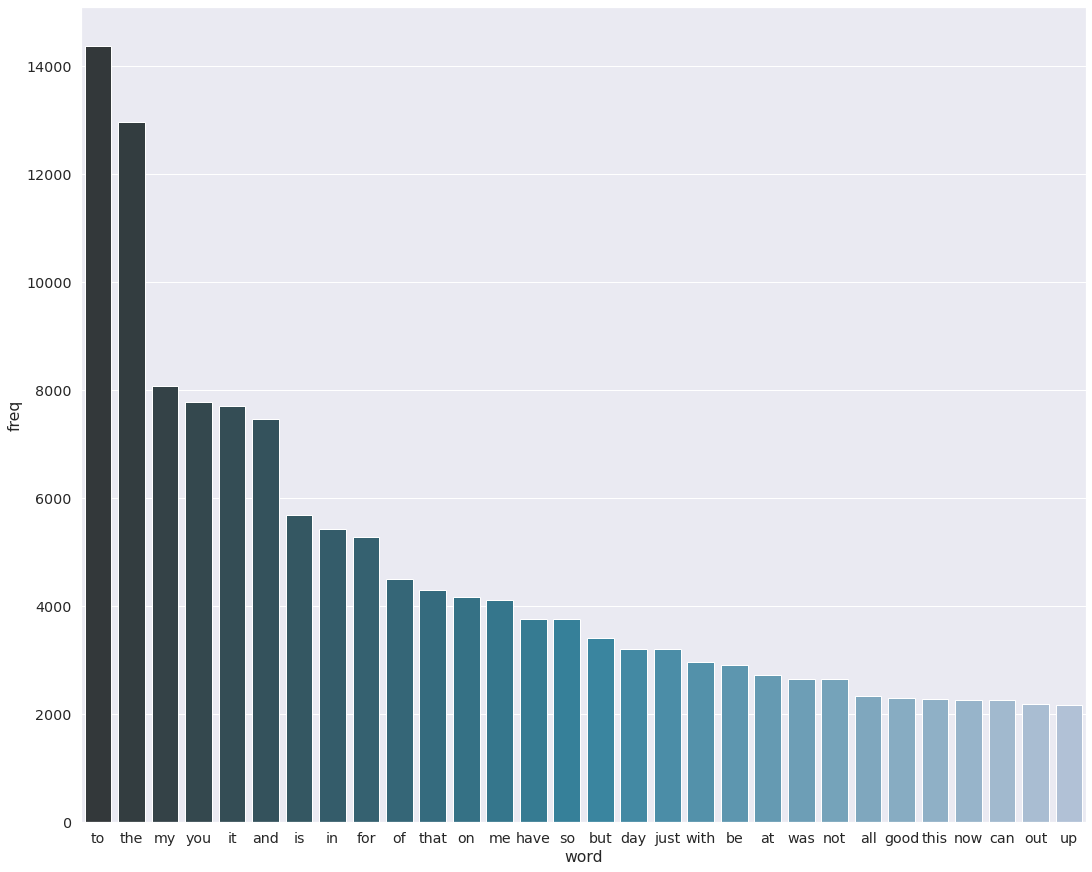

In [ ]:
cv = CountVectorizer()

bow = cv.fit_transform(sr_clean)

word_freq = dict(zip(cv.get_feature_names(), np.asarray(bow.sum(axis=0)).ravel()))

word_counter = collections.Counter(word_freq)

word_counter_df = pd.DataFrame(word_counter.most_common(30),columns = ['word','freq'])

fig, ax = plt.subplots(figsize=(18,15))

sns.barplot(x="word", y="freq", data=word_counter_df, palette="PuBuGn_d" , ax=ax)

plt.show();

***Train-Test***

In [ ]:
# Based on http://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html
def grid_vect(clf, parameters_clf, X_train, X_test, parameters_text=None, vect=None, is_w2v=False):
    
    textcountscols = ['count_capital_words','count_emojis','count_excl_quest_marks','count_hashtags'
                      ,'count_mentions','count_urls','count_words']
    
    if is_w2v:
        w2vcols = []
        for i in range(SIZE):
            w2vcols.append(i)
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('w2v', ColumnExtractor(cols=w2vcols))]
                                , n_jobs=-1)
    else:
        features = FeatureUnion([('textcounts', ColumnExtractor(cols=textcountscols))
                                 , ('pipe', Pipeline([('cleantext', ColumnExtractor(cols='clean_text')), ('vect', vect)]))]
                                , n_jobs=-1)

    
    pipeline = Pipeline([
        ('features', features)
        , ('clf', clf)
    ])
    
    # Join the parameters dictionaries together
    parameters = dict()
    if parameters_text:
        parameters.update(parameters_text)
    parameters.update(parameters_clf)

    # Make sure you have scikit-learn version 0.19 or higher to use multiple scoring metrics
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1, cv=5)
    
    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)

    t0 = time()
    grid_search.fit(X_train, y_train)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best CV score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))
        
    print("Test score with best_estimator_: %0.3f" % grid_search.best_estimator_.score(X_test, y_test))
    print("\n")
    print("Classification Report Test Data")
    print(classification_report(y_test, grid_search.best_estimator_.predict(X_test)))
                        
    return grid_search

In [ ]:
# Parameter grid settings for the vectorizers (Count and TFIDF)
parameters_vect = {
    'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
    'features__pipe__vect__ngram_range': ((1, 1), (1, 2)),
    'features__pipe__vect__min_df': (1,2)
}


# Parameter grid settings for MultinomialNB
parameters_mnb = {
    'clf__alpha': (0.25, 0.5, 0.75)
}


# Parameter grid settings for LogisticRegression
parameters_logreg = {
    'clf__C': (0.25, 0.5, 1.0),
    'clf__penalty': ('l1', 'l2')
}


In [ ]:
class ColumnExtractor(TransformerMixin, BaseEstimator):

  def __init__(self,cols):

    self.cols = cols

  def transform(self, X, **transform_params):

    return X[self.cols]

  def fit(self,X, y=None, **fit_params):

    return self

In [ ]:
class TextCounts(BaseEstimator, TransformerMixin):

  def count_regex(self, pattern, tweet):

    return len(re.findall(pattern, tweet))




  def fit(self, X, y=None, **fit_params):

    #fit method is used when specific operations need to be done on the train data, but not on the test data

    return self




  def transform(self, X, **transform_params):

    count_words = X.apply(lambda x: self.count_regex(r'\w+', x))

    count_mentions = X.apply(lambda x: self.count_regex(r'@\w+', x))

    count_hashtags = X.apply(lambda x: self.count_regex(r'#\w+', x)) 

    count_capital_words = X.apply(lambda x: self.count_regex(r'\b[A-Z]{2,}\b', x))

    count_excl_quest_marks = X.apply(lambda x: self.count_regex(r'!|\?', x))

    count_urls = X.apply(lambda x: self.count_regex(r'http.?://[^\s]+[\s]?', x)) 

    #We will replace the emoji symbols with a description, which makes using a regex for counting easier

    #Moreover, it will result in having more words in the tweet

    count_emojis = X.apply(lambda x: emoji.demojize(x)).apply(lambda x: self.count_regex(r'[a-z_&]+:', x))




    df = pd.DataFrame({'count_words': count_words

                       , 'count_mentions': count_mentions

                       , 'count_hashtags': count_hashtags

                       , 'count_capital_words': count_capital_words

                       , 'count_excl_quest_marks': count_excl_quest_marks

                       , 'count_urls': count_urls

                       , 'count_emojis': count_emojis})

    return df

tc = TextCounts()

emotions_eda = tc.fit_transform(emotions_train.content)

emotions_eda['sentiment'] = emotions_train.sentiment

In [ ]:
df_model = emotions_eda

df_model['clean_text'] = sr_clean

df_model.columns.tolist()

X_train, X_test, y_train, y_test = train_test_split(df_model.drop('sentiment', axis=1), df_model.sentiment, test_size=0.1, random_state=37)

mnb = MultinomialNB()

logreg = LogisticRegression()

countvect = CountVectorizer() # MultinomialNB

best_mnb_countvect = grid_vect(mnb, parameters_mnb, X_train, X_test, parameters_text=parameters_vect, vect=countvect)

#joblib.dump(best_mnb_countvect, ' ../output/best_mnb_countvect.pkl')#LogisticRegression

best_logreg_countvect = grid_vect(logreg, parameters_logreg, X_train, X_test , parameters_text=parameters_vect, vect=countvect)

#joblib.dump(best_logreg_countvect, ' ../output/best_logreg_countvect.pkl')

Performing grid search...
pipeline: ['features', 'clf']
parameters:
{'clf__alpha': (0.25, 0.5, 0.75),
 'features__pipe__vect__max_df': (0.25, 0.5, 0.75),
 'features__pipe__vect__min_df': (1, 2),
 'features__pipe__vect__ngram_range': ((1, 1), (1, 2))}
Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   48.0s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  3.1min finished


done in 190.056s

Best CV score: 0.330
Best parameters set:
	clf__alpha: 0.75
	features__pipe__vect__max_df: 0.5
	features__pipe__vect__min_df: 2
	features__pipe__vect__ngram_range: (1, 2)
Test score with best_estimator_: 0.329


Classification Report Test Data
              precision    recall  f1-score   support

       anger       0.00      0.00      0.00        10
     boredom       0.00      0.00      0.00        15
       empty       0.00      0.00      0.00        80
  enthusiasm       0.00      0.00      0.00        73
         fun       0.33      0.01      0.01       180
   happiness       0.33      0.38      0.35       504
        hate       0.67      0.01      0.03       144
        love       0.48      0.33      0.39       405
     neutral       0.32      0.47      0.38       829
      relief       0.00      0.00      0.00       148
     sadness       0.30      0.22      0.26       539
    surprise       0.25      0.00      0.01       214
       worry       0.32      0.55  

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   34.7s


KeyboardInterrupt: ignored

In [ ]:
emotion_file = files.upload()
emotion_file = open('emotions.txt', encoding = 'utf-8').read()

Saving emotions.txt to emotions.txt


In [ ]:
emo = []
sample = []
for line in emotion_file.replace('\n' , '').split(','):
  sample.append(line.strip(':'))
sample  


KeyboardInterrupt: ignored

In [ ]:
sample = emotion_file.replace('\n', '')
sample1 = sample.split(',')

sample1

sample2 = []
for line in sample1:
    sample2.append(line.strip())

sample3 = []
for line in sample2:
    sample3.append(line.split(':'))

sample4 = []
for line1 in sample3:
    for line in line1:
        sample4.append(line.strip())

sample5 = []
for word in sample4:
    sample5.append(word.replace("'", ""))

words_list = []
emotions = []
i = 0
for word in sample5:
    if i == 0:
        words_list.append(word)
        i = 1
    elif i == 1:
        emotions.append(word)
        i = 0

**bold text**

In [ ]:
text_file = files.upload() 
text_file = open('read.txt',encoding='utf-8').read()
#Here read.txt is the inputted database file to be analysed
emotion_file = files.upload()
emotion_file = open('emotions.txt',encoding='utf-8').read() 
#Here emotion.txt contains several emotion depicting words


Saving read.txt to read.txt


Saving emotions.txt to emotions.txt


***Tokenize Text***

In [ ]:
from nltk.tokenize import sent_tokenize, word_tokenize
tokenized_text = sent_tokenize(emotions_train.content)
print(tokenized_text)

SyntaxError: ignored